## Import Libraries and Check GPU Avalailability

In [1]:
import os
import tensorflow as tf
import logging
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, \
BatchNormalization, Conv2D, MaxPooling2D, RandomRotation, RandomZoom, RandomTranslation,\
RandomBrightness, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.get_logger().setLevel(logging.ERROR)

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

: /physical_device:CPU:0
: /physical_device:GPU:0


## Import Data and Divide into training and validation

In [3]:
# set seeds and variables
SEED = 1234
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 8
TRAINING_DATA_PATH = "Final_Arabic_Alpha_dataset" + '/train'
TEST_DATA_PATH = "Final_Arabic_Alpha_dataset" + '/test'

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
training_dataset = image_dataset_from_directory(
    TRAINING_DATA_PATH,
    validation_split=0.2,
    color_mode='grayscale',
    label_mode='int',
    subset='training',
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = training_dataset.class_names

validation_dataset = image_dataset_from_directory(
    TRAINING_DATA_PATH,
    validation_split=0.2,
    color_mode='grayscale',
    label_mode='int',
    subset='validation',
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 42559 files belonging to 65 classes.
Using 34048 files for training.
Found 42559 files belonging to 65 classes.
Using 8511 files for validation.


## Visualize the Data

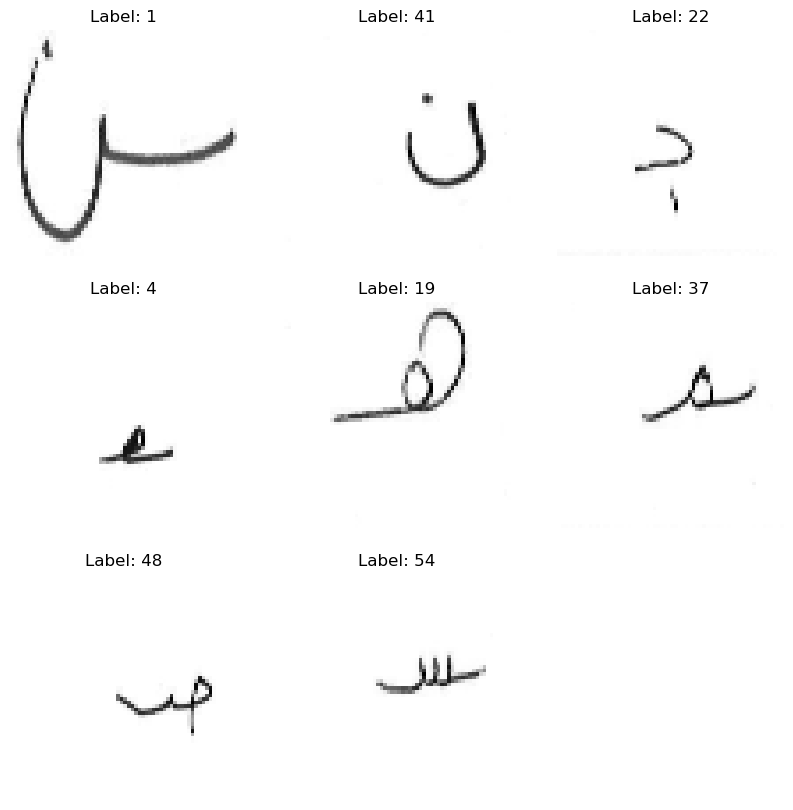

In [5]:
for images, labels in training_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        label = class_names[labels[i].numpy()]  # Map index to class name
        plt.title(f"Label: {label}")
        plt.axis("off")

## Build Model

### Apply Data Augmentation

In [6]:
data_augmentation = Sequential([
    RandomRotation(0.2, seed=SEED),
    RandomZoom(0.1, seed=SEED),
    RandomTranslation(0.1, 0.1, seed=SEED),
    Rescaling(1./255)
], name="data_augmentation")

# MobileNetV2

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Resizing, Lambda

preprocessing_layers = Sequential([
    Input(shape=(64, 64, 1)),
    data_augmentation,
    Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
    Resizing(128, 128)
])

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

base_model.trainable = True

model = Sequential([
    Input(shape=(64,64,1)),
    preprocessing_layers,
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 256)               327936    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

## Training

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
epochs = 10

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks = [reduce_lr]
)

Epoch 1/10


4256/4256 [==============================] - 302s 69ms/step - loss: 2.4937 - accuracy: 0.3419 - val_loss: 1.2865 - val_accuracy: 0.6206 - lr: 1.0000e-04
Epoch 2/10
4256/4256 [==============================] - 270s 63ms/step - loss: 1.2537 - accuracy: 0.6414 - val_loss: 1.0334 - val_accuracy: 0.7012 - lr: 1.0000e-04
Epoch 3/10
4256/4256 [==============================] - 300s 71ms/step - loss: 0.9435 - accuracy: 0.7267 - val_loss: 0.8834 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 4/10
4256/4256 [==============================] - 308s 72ms/step - loss: 0.7881 - accuracy: 0.7706 - val_loss: 0.4690 - val_accuracy: 0.8623 - lr: 1.0000e-04
Epoch 5/10
4256/4256 [==============================] - 266s 63ms/step - loss: 0.6934 - accuracy: 0.7998 - val_loss: 0.7313 - val_accuracy: 0.7914 - lr: 1.0000e-04
Epoch 6/10
4256/4256 [==============================] - 345s 81ms/step - loss: 0.6299 - accuracy: 0.8122 - val_loss: 0.6151 - val_accuracy: 0.8227 - lr: 1.0000e-04
Epoch 7/10
4256/4256 [=====

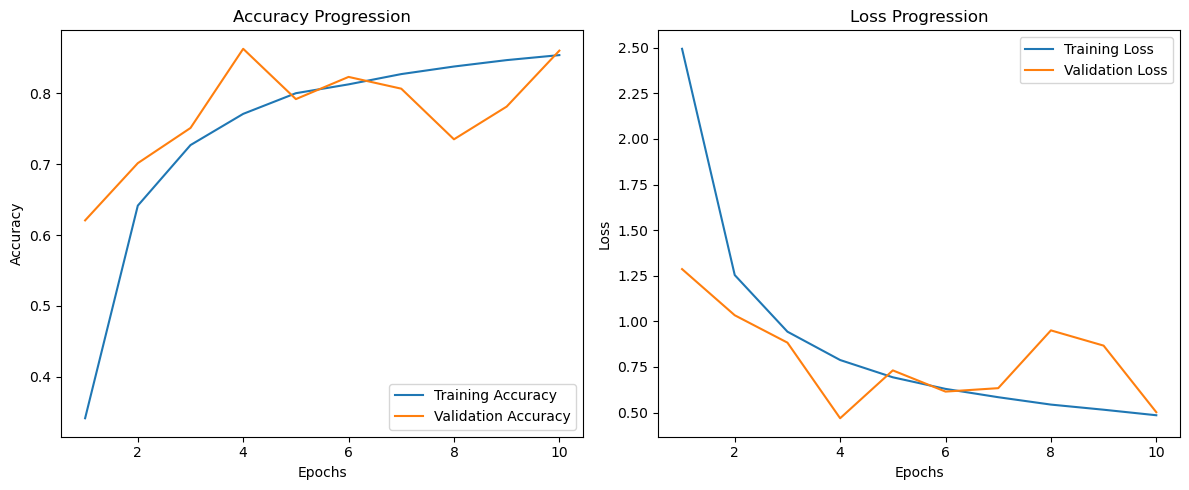

In [15]:
history_dict = history.history

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])
loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
if val_accuracy:
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Progression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ResNet

In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models
from tensorflow.keras.layers import Resizing, Lambda

data_augmentation = Sequential([
    RandomRotation(0.2, seed=SEED),
    RandomZoom(0.1, seed=SEED),
    RandomTranslation(0.1, 0.1, seed=SEED),
    Rescaling(1./255)
], name="data_augmentation")

preprocessing_layers = Sequential([
    Input(shape=(64, 64, 1)),
    data_augmentation,
    Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
    Resizing(224, 224)
])

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

inputs = tf.keras.Input(shape=(64, 64, 1))
x = preprocessing_layers(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(len(class_names), activation='softmax')(x)

rsn_model = models.Model(inputs, outputs)

rsn_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
rsn_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_22 (Dense)            (None, 256)               524544    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                           

In [29]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)
epochs = 10

history = rsn_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks = [reduce_lr]
)

Epoch 1/10
4256/4256 [==============================] - 596s 139ms/step - loss: 2.1582 - accuracy: 0.4380 - val_loss: 3.0774 - val_accuracy: 0.3105 - lr: 1.0000e-04
Epoch 2/10
4256/4256 [==============================] - 582s 137ms/step - loss: 0.9671 - accuracy: 0.7327 - val_loss: 0.9254 - val_accuracy: 0.7474 - lr: 1.0000e-04
Epoch 3/10
4256/4256 [==============================] - 588s 138ms/step - loss: 0.7508 - accuracy: 0.7880 - val_loss: 0.5223 - val_accuracy: 0.8456 - lr: 1.0000e-04
Epoch 4/10
4256/4256 [==============================] - 567s 133ms/step - loss: 0.6292 - accuracy: 0.8189 - val_loss: 0.5477 - val_accuracy: 0.8414 - lr: 1.0000e-04
Epoch 5/10
4256/4256 [==============================] - 572s 134ms/step - loss: 0.5632 - accuracy: 0.8354 - val_loss: 0.5445 - val_accuracy: 0.8399 - lr: 1.0000e-04
Epoch 6/10
4256/4256 [==============================] - 530s 125ms/step - loss: 0.5123 - accuracy: 0.8475 - val_loss: 0.4064 - val_accuracy: 0.8818 - lr: 1.0000e-04
Epoch 7/10

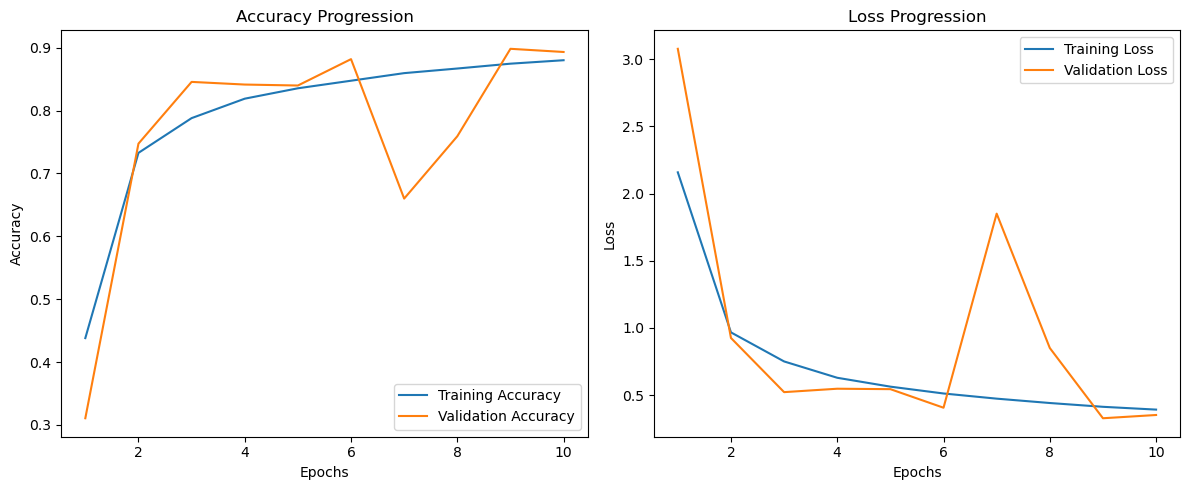

In [30]:
history_dict = history.history

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])
loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
if val_accuracy:
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Progression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Predict labels for the Test Data

In [31]:
test_dataset = image_dataset_from_directory(
        TEST_DATA_PATH,
        labels=None,
        label_mode="int",
        color_mode='grayscale',
        shuffle=False,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE)

Found 10640 files belonging to 1 classes.


In [32]:
predictions = rsn_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

1330/1330 [==============================] - 29s 20ms/step


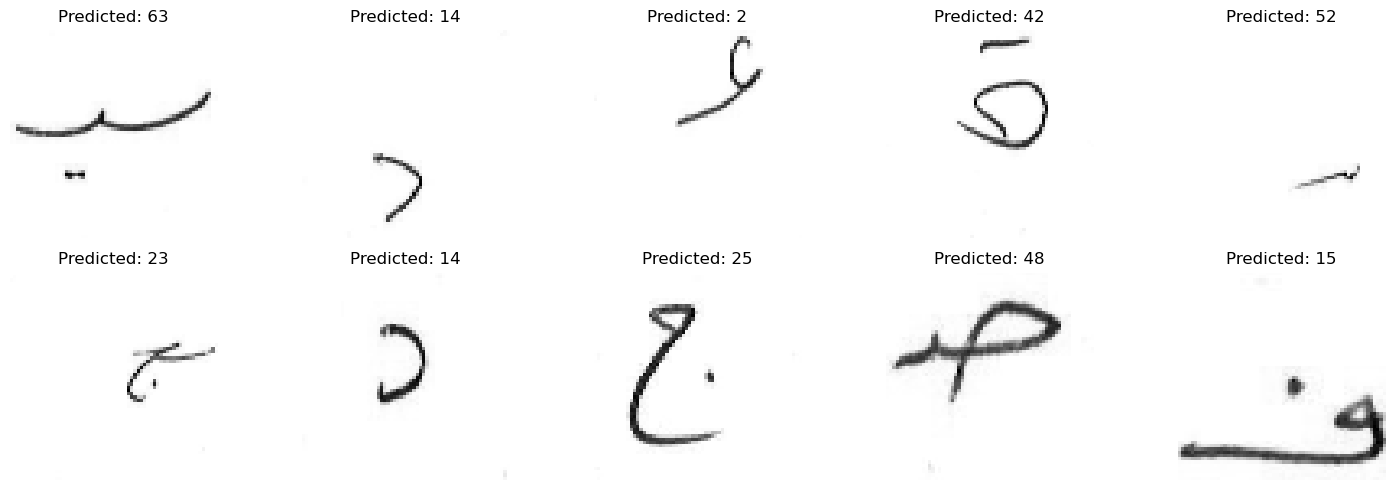

In [33]:
import random
images = []
for batch in test_dataset:
    images.extend(batch.numpy())

sample_size = 10
sample_indices = random.sample(range(len(images)), sample_size)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    predicted_class = class_names[predicted_labels[idx]]
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()